 ### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
from collections import deque
import pickle

# for building DQN model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import time
# for plotting graphs
import matplotlib.pyplot as plt
from typing import List

# Import the environment
from Env import CabDriver

 #### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

 #### Tracking the state-action pairs for checking convergence


In [3]:
# Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

 ### Agent Class

 If you are using this framework, you need to fill the following to complete the following code block:
 1. State and Action Size
 2. Hyperparameters
 3. Create a neural-network model in function 'build_model()'
 4. Define epsilon-greedy strategy in function 'get_action()'
 5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
 6. Complete the 'train_model()' function with following logic:
    - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
       - Initialise your input and output batch for training the model
       - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
       - Get Q(s', a) values from the last trained model
       - Update the input batch as your encoded state and output batch as your Q-values
       - Then fit your DQN model using the updated input and output batch.

In [4]:
env = CabDriver()


class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon_max = 1.0
        self.epsilon = 1
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001

        self.batch_size = 32
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

        self.states_tracked = []
        self.track_state = np.array(env.state_encoded_arch1([0, 0, 0])).reshape(1, 36)

    # approximate Q function using Neural Network

    def build_model(self, print_summary=True):
        """Builds and retuns NN model for DQN

        Args:
            print_summary (bool, optional): Model summary will be printed if value is True. Defaults to True.

        Returns:
            [type]: Compiled Tensorflow model
        """
        # Write your code here: Add layers to your neural nets
        model = Sequential([
            Dense(32, activation='relu', input_dim=self.state_size),
            Dense(32, activation='relu'),
            # the output layer: output is of size num_actions
            Dense(self.action_size, activation='relu')
        ])

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        if print_summary:
            model.summary()
        return model

    def get_action(self, state: List[int]):
        """Get action for a given state based on epsilon greedy stretegy

        Args:
            state (List[int]): State of game

        Returns:
            [type]: indicies of possible actions
        """
        possible_actions_index, _ = env.requests(state)
        choice_value = np.random.rand() <= self.epsilon
        # Write your code here:
        if (choice_value):
            # Explore
            return random.choice(possible_actions_index)
        else:
            # Exploit
            state_reshaped = np.array(env.state_encoded_arch1(state)).reshape(1, 36)
            q_value = self.model.predict(state_reshaped)[0]
            q_values_possible = [q_value[i] for i in possible_actions_index]
            # if len(possible_actions_index) <= 0:
            #     print(
            #         f"get_action-possible_actions_index: {possible_actions_index}\nget_action-state for no possible action : {state}\nget_action-qvalue: {q_value} \nget_action-possible q values: {q_values_possible}")

            return possible_actions_index[np.argmax(q_values_possible)]

    def append_sample(self, state, action, reward, next_state, done):
        """ Appends current details to memory"""
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory

        # pick samples randomly from replay memory (with batch_size) and train the network
        self.memory.append((state, action, reward, next_state, done))

    def train_model(self):
        """Train DL model for DQN"""
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))  # write here
            update_input = np.zeros((self.batch_size, self.state_size))   # write here

            actions, rewards, done = [], [], []

            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encoded_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encoded_arch1(next_state)
                done.append(done_boolean)

            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            # 2. Get the target for the Q-network
            target_q_values = self.model.predict(update_output)
            # 3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else:  # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_q_values[i])
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)

        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])

    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)

        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])

    def save(self, name):
        self.model.save(name)


In [5]:
episode_time = 24 * 30
EPISODES = 5000 # Running 5000 episoded due to slow computer
m = 5  # number of cities, ranges from 1 ..... m
t = 24  # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1
action_space, state_space, state = env.reset()
state_size = m + t + d
action_size = len(action_space)
agent = DQNAgent(action_size=action_size, state_size=state_size)
rewards_per_episode, episodes = [], []
rewards_init_state = []


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1184      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


D:\Users\SYadavConda\anaconda3\envs\e38\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


 ### DQN block

In [6]:

start_time = time.time()
score_tracked = []
for episode in range(EPISODES):

    # Write code here
    # Call the environment
    # Call all the initialized variables of the environment

    # Call the DQN agent
    done = False
    score = 0
    track_reward = False

    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init

    total_time = 0

    while not done:
        action = agent.get_action(state)
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        total_time += step_time
        if (total_time > episode_time):
            done = True
        else:
            agent.append_sample(state, action, reward, next_state, done)
            agent.train_model()
            score += reward
            state = next_state

    rewards_per_episode.append(score)
    episodes.append(episode)

    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    if ((episode + 1) % 100 == 0):
        print(f"episode {episode}, reward {score}, memory_length {len(agent.memory)}, epsilon {agent.epsilon} total_time {total_time}")
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")

elapsed_time = time.time() - start_time

Saving Model 0
INFO:tensorflow:Assets written to: model_weights.pkl\assets
episode 99, reward -60.0, memory_length 2000, epsilon 0.9516956410848808 total_time 724.0
episode 199, reward 42.0, memory_length 2000, epsilon 0.9052808969690094 total_time 727.0
episode 299, reward 181.0, memory_length 2000, epsilon 0.8611298266353209 total_time 726.0
episode 399, reward 386.0, memory_length 2000, epsilon 0.819132029410716 total_time 729.0
episode 499, reward 252.0, memory_length 2000, epsilon 0.7791824889264571 total_time 722.0
episode 599, reward 291.0, memory_length 2000, epsilon 0.7411813105225479 total_time 721.0
episode 699, reward 523.0, memory_length 2000, epsilon 0.7050334714590482 total_time 733.0
episode 799, reward 296.0, memory_length 2000, epsilon 0.670648583309731 total_time 723.0
episode 899, reward 661.0, memory_length 2000, epsilon 0.6379406659439346 total_time 729.0
episode 999, reward 638.0, memory_length 2000, epsilon 0.6068279325314512 total_time 726.0
Saving Model 1000
I

In [7]:
agent.save(name="model_weights.pkl")

INFO:tensorflow:Assets written to: model_weights.pkl\assets


In [8]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]


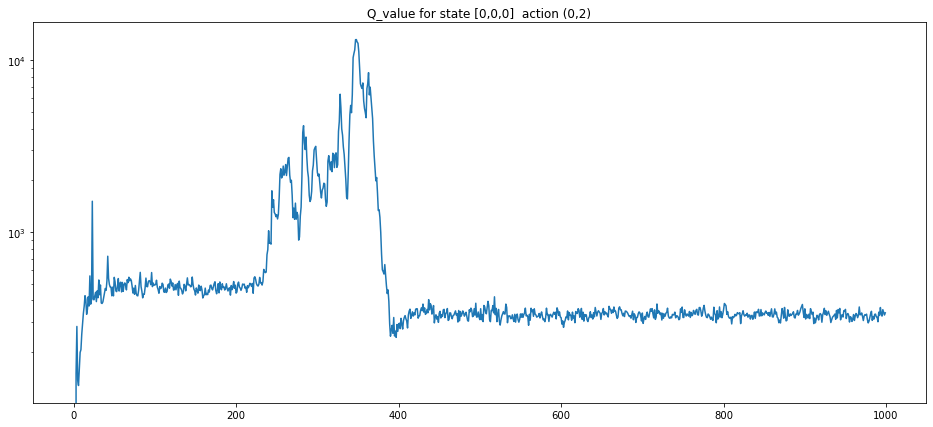

In [9]:
plt.figure(0, figsize=(16, 7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
x_axis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(x_axis, np.asarray(agent.states_tracked))
plt.show()

 ### Tracking Convergence

**As we can see that model Q-Value is Converged**

 #### Epsilon-decay sample function

 <div class="alert alert-block alert-info">
 Try building a similar epsilon-decay function for your model.
 </div>

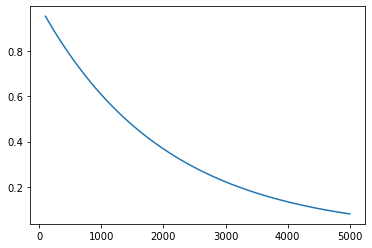

In [2]:
# Copied and formatted from bove, Using manual as forgot to add in tracking and re-running code will take 2 days
episodes = [99,199,299,399,499,599,699,799,899,999,1099,1199,1299,1399,1499,1599,1699,1799,1899,1999,2099,2199,2299,2399,2499,2599,2699,2799,2899,2999,3099,3199,3299,3399,3499,3599,3699,3799,3899,3999,4099,4199,4299,4399,4499,4599,4699,4799,4899,4999]
epsilon_values = [0.9516956410848808,0.9052808969690094,0.8611298266353209,0.819132029410716,0.7791824889264571,0.7411813105225479,0.7050334714590482,0.670648583309731,0.6379406659439346,0.6068279325314512,0.5772325850328504,0.5490806196638577,0.5223016418473468,0.49682869019022974,0.47259806904509577,0.4495491892379152,0.4276244165635446,0.4067689276701942,0.38693057297249134,0.3680597462503545,0.3501092606076035,0.3330342304801412,0.3167919593986629,0.30134183322524366,0.28664521859683867,0.2726653663217522,0.25936731948751673,0.24671782605040335,0.23468525568799242,0.22323952070689196,0.21235200080783204,0.2019954715200092,0.19214403612572878,0.18277306090512138,0.17385911353901257,0.1653799045159192,0.15731423139666081,0.14964192579721786,0.1423438029572661,0.13540161376828327,0.12879799914127205,0.12251644659999568,0.11654124899118631,0.11085746520848058,0.10545088283187094,0.10030798258925279,0.0954159045512026,0.09076241597445547,0.0863358807136757,0.08212523012503205]
plt.plot(episodes, epsilon_values)
plt.show()